# MNIST Handwritten Digit Recognition: Fundamentals of Neural Networks

This notebook introduces deep learning fundamentals using the MNIST handwritten digits dataset, with a focus on building intuition through clear baselines and simple experiments.

## Project goals

- Build a feedforward neural network (MLP) for digit classification and understand the main training workflow (train/validate/test).
- Compare the neural network against two classical baselines:
  - Logistic Regression
  - Decision Tree
- Learn how to evaluate models fairly using the same data splits and consistent metrics, and why baselines matter before adding complexity. [file:75]

## What this notebook will include

- Data loading and preprocessing for MNIST (normalization, train/validation/test split).
- Baseline 1: Logistic Regression (fast, strong reference point).
- Baseline 2: Decision Tree (interpretable, non-linear baseline).
- Model 3: Feedforward neural network (dense layers) with a simple, reproducible setup.
- Side-by-side comparison:
  - Accuracy and confusion matrix
  - Training time and practical tradeoffs
  - Common errors and what they suggest to improve next

## Project phases

### 1) Setup
- Import libraries and set seeds for reproducibility.
- Define a common evaluation plan (same splits, same metrics for all models). 

### 2) Data preparation
- Load MNIST.
- Normalize inputs and create train/validation/test splits.

### 3) Baseline models
- Train Logistic Regression as a fast reference point.
- Train a Decision Tree as an interpretable non-linear baseline. 

### 4) Feedforward neural network
- Build a small MLP (dense layers).
- Train with a clear training loop and validation monitoring.

### 5) Evaluation and comparison
- Compare all models on the test set using the same metrics.
- Add a confusion matrix and inspect the most common mistakes.

### 6) Short conclusions
- Summarize tradeoffs (accuracy, training time, simplicity).
- List 2–3 concrete next improvements (regularization, tuning, better preprocessing).


##  Setup + MNIST context

### What MNIST is
MNIST is a small, beginner-friendly dataset of handwritten digit images (0–9) used for classification.  
It is widely used as a first deep learning dataset because it is simple to load, trains quickly, and makes it easy to compare models fairly before moving to harder vision problems.

### What we do in this phase
- Import the core libraries (NumPy, scikit-learn, and a deep learning framework for the MLP).
- Set random seeds so results are reproducible across runs.
- Define a consistent evaluation plan (same train/validation/test split and the same metrics for every model), because disciplined baselines and honest measurement matter more than “fancy” modeling. 


In [4]:
# Core
import numpy as np
import random

# Visualization
import matplotlib.pyplot as plt

# Classical ML baselines
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Deep learning (for MNIST + feedforward network later)
import tensorflow as tf

# Reproducibility: set Python + NumPy + TensorFlow seeds in one call
SEED = 42
tf.keras.utils.set_random_seed(SEED)

## Load MNIST + quick inspection

Load the MNIST dataset and do a fast sanity check before training anything. The goal is to confirm the data shapes and visually verify that the labels match the digit images.

- Load `(x_train, y_train)` and `(x_test, y_test)`.
- Print the shapes of images and labels.
- Display a **2×5** grid of random training images with their labels.


x_train shape: (60000, 28, 28) | y_train shape: (60000,)
x_test  shape: (10000, 28, 28) | y_test  shape: (10000,)


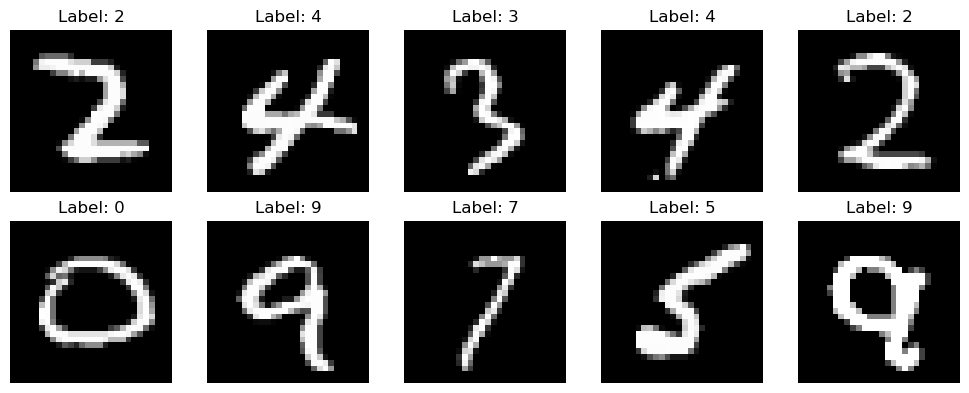

In [6]:
# Load MNIST (returns 2 tuples: train and test) 
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Check shapes (sanity check) [web:91]
print("x_train shape:", x_train.shape, "| y_train shape:", y_train.shape)
print("x_test  shape:", x_test.shape,  "| y_test  shape:", y_test.shape)



In [ ]:
# Show a 2×5 grid of random training images
rng = np.random.default_rng(42)
idx = rng.choice(len(x_train), size=10, replace=False)  # random indices 

fig, axes = plt.subplots(2, 5, figsize=(10, 4))
axes = axes.ravel()

for ax, i in zip(axes, idx):
    ax.imshow(x_train[i], cmap="gray")
    ax.set_title(f"Label: {y_train[i]}")
    ax.axis("off")  # hide axes per subplot 

plt.tight_layout()
plt.show()

## Data Preparation

Normalize the MNIST pixel values so all inputs are on a consistent scale (e.g., 0–1). This helps training behave more predictably and makes model comparisons fair.

Create three splits:
- **Train:** used to fit model parameters.
- **Validation:** used to tune choices (model size, learning rate) without touching the test set.
- **Test:** used once at the end for an honest final result.


In [8]:
from sklearn.model_selection import train_test_split

# --- Normalize ---
# MNIST pixels are in [0, 255]. Convert to float32 and scale to [0, 1].
x_train = x_train.astype("float32") / 255.0 
x_test  = x_test.astype("float32") / 255.0  

# --- Create train/validation split ---
# Keep the original x_test/y_test as the final test set.
# Split x_train into train and validation, preserving label proportions. [web:141][web:143]
X_train, X_val, y_train, y_val = train_test_split(
    x_train,
    y_train,
    test_size=0.2,
    random_state=42,
    stratify=y_train
)

print("Train:", X_train.shape, y_train.shape)
print("Val:  ", X_val.shape, y_val.shape)
print("Test: ", x_test.shape, y_test.shape)

Train: (48000, 28, 28) (48000,)
Val:   (12000, 28, 28) (12000,)
Test:  (10000, 28, 28) (10000,)


## Baseline models

Before building a neural network, train simple baseline models to establish a clear reference point and ensure the evaluation is honest. Baselines help verify that the data pipeline is correct and prevent unnecessary complexity when simpler models already perform well.

- **Logistic Regression:** Train this first. It is fast, effective for many classification tasks, and provides a solid minimum performance benchmark to beat.
- **Decision Tree:** Use this as an interpretable non-linear baseline. It enables comparison between a simple rule-based model and more complex learning approaches.

Use the same train/validation split and the same evaluation metrics for both baseline models.


In [10]:
# sklearn models expect 2D inputs: (n_samples, n_features)
# Flatten 28x28 images to 784-length vectors
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat   = X_val.reshape(X_val.shape[0], -1)
X_test_flat  = x_test.reshape(x_test.shape[0], -1)

# ---- Baseline 1: Logistic Regression ----
log_reg = LogisticRegression(
    multi_class="multinomial",
    solver="lbfgs",
    max_iter=300,
    n_jobs=-1
)  # multinomial supported by lbfgs 

log_reg.fit(X_train_flat, y_train)
val_pred_lr = log_reg.predict(X_val_flat)

print("LogReg validation accuracy:", accuracy_score(y_val, val_pred_lr))
print("LogReg confusion matrix (val):\n", confusion_matrix(y_val, val_pred_lr))

# ---- Baseline 2: Decision Tree ----
tree = DecisionTreeClassifier(
    random_state=42
)  # basic classifier API: fit/predict 

tree.fit(X_train_flat, y_train)
val_pred_tree = tree.predict(X_val_flat)

print("Decision Tree validation accuracy:", accuracy_score(y_val, val_pred_tree))
print("Decision Tree confusion matrix (val):\n", confusion_matrix(y_val, val_pred_tree))

LogReg validation accuracy: 0.9215833333333333
LogReg confusion matrix (val):
 [[1148    0    3    1    1   16    7    1    5    3]
 [   0 1309   10    4    1    5    1    1   14    3]
 [   9   14 1061   26    9    4   20    8   35    6]
 [   3    5   35 1101    1   36    1    6   30    8]
 [   4    3    6    1 1086    1    9    5    7   46]
 [  11    3    9   33   14  960   14    2   28   10]
 [   7    3    6    1   14   22 1125    0    5    1]
 [   4    5   18    5    9    3    2 1160    5   42]
 [  14   23   15   31    5   37   14    2 1018   11]
 [   3   10    2   12   23    7    1   35    6 1091]]
Decision Tree validation accuracy: 0.8700833333333333
Decision Tree confusion matrix (val):
 [[1087    1   14   10   11   16   17    8   12    9]
 [   1 1280   15   14    6    8    2    2   14    6]
 [  14   14 1001   44   20   13   20   22   33   11]
 [   8    7   31 1028   11   55    8   10   45   23]
 [   7   10   14    9 1011   13    8   18   21   57]
 [  15    7   18   43   12  894 

To compare the baselines visually, we plot their confusion matrices side by side using Matplotlib subplots and scikit-learn’s `ConfusionMatrixDisplay`.

- We create a `1×2` figure using `plt.subplots(1, 2, ...)`.
- We plot the Logistic Regression confusion matrix on the left axis.
- We plot the Decision Tree confusion matrix on the right axis.
- We use consistent labels and a shared color style so the two plots are easy to compare.


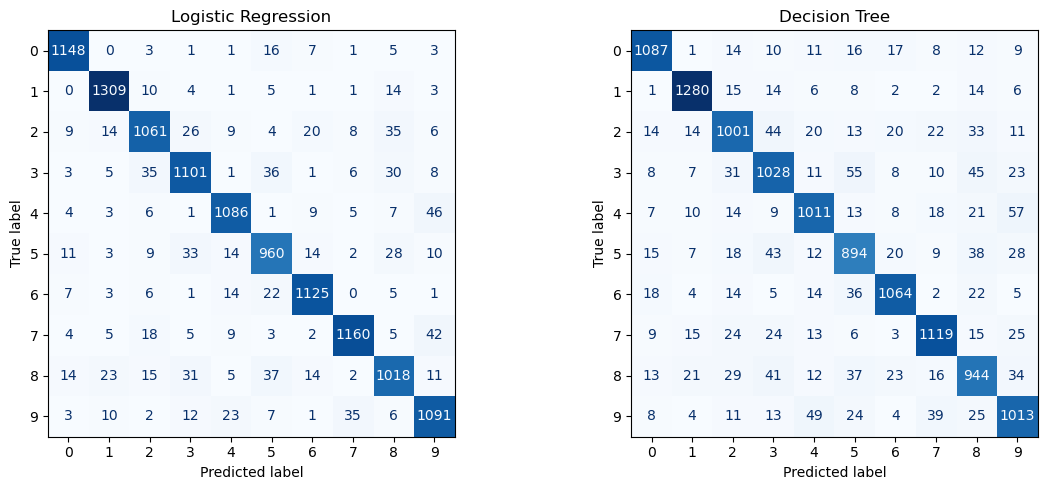

In [12]:
from sklearn.metrics import ConfusionMatrixDisplay  

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ConfusionMatrixDisplay.from_predictions(
    y_val, val_pred_lr, ax=axes[0], cmap="Blues", colorbar=False
)  # from_predictions supports ax=... 
axes[0].set_title("Logistic Regression")

ConfusionMatrixDisplay.from_predictions(
    y_val, val_pred_tree, ax=axes[1], cmap="Blues", colorbar=False
)  # from_predictions supports ax=...
axes[1].set_title("Decision Tree")

plt.tight_layout()
plt.show()


## Feedforward neural network (MLP)

Now build a small **multilayer perceptron (MLP)** using fully connected (Dense) layers. An MLP treats each image as a vector of numbers, learns transformations through hidden layers, and outputs one score per digit class.

**Architecture (simple and effective for a first notebook):**
- **Input:** Flatten each 28×28 image into a 784-length vector so it can be fed into Dense layers.
- **Hidden layers:** 1–2 Dense layers (for example, 128 units each) with ReLU activation to learn non-linear patterns.
- **Output layer:** Dense layer with 10 units (one per digit 0–9) with Softmax activation to produce class probabilities.

**Training approach:**
- Train for a small number of epochs and monitor performance on the validation set at each epoch.
- Optionally use early stopping to stop training when validation performance stops improving, helping avoid overfitting and unnecessary training.


In [14]:
mlp = tf.keras.Sequential(
    [
        tf.keras.layers.Input(shape=(28, 28)),
        tf.keras.layers.Flatten(),  # convert 28x28 image to a 1D vector 
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(10, activation="softmax"),
    ],
    name="mnist_mlp",
)

# Compile is optional for summary, but typically done before training.
mlp.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

# Show architecture, output shapes, and parameter counts.
mlp.summary()

Model: "mnist_mlp"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         100,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 118,282 (462.04 KB)

 Trainable params: 118,282 (462.04 KB)

 Non-trainable params: 0 (0.00 B)

## Train the MLP (standard training)

Now train the feedforward network using the training set and monitor performance on the validation set each epoch. This keeps the workflow honest: the model learns on training data, while validation shows how well it generalizes during training. 

**What training means here**
- Run several **epochs** (full passes over the training data) where the model updates its weights to reduce the loss. 
- Use a **batch size** (small groups of examples) to make training efficient and stable. 
- Track both loss and accuracy for training and validation so it’s clear whether the model is improving or starting to overfit.

**What you will do**
- Call `model.fit(...)` with `X_train, y_train` and `validation_data=(X_val, y_val)` to train and log metrics each epoch. 
- Save the returned `history` object so you can plot learning curves (training vs validation) in the next step.


In [16]:
# Train the MLP and monitor validation each epoch (no early stopping yet). 
history = mlp.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),  # validation is evaluated each epoch, not trained on 
    epochs=10,
    batch_size=32,
    verbose=1
)

# Optional: see what was recorded
print(history.history.keys())  # history.history stores per-epoch metrics 


Epoch 1/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.8706 - loss: 0.4495 - val_accuracy: 0.9572 - val_loss: 0.1391
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9644 - loss: 0.1194 - val_accuracy: 0.9679 - val_loss: 0.1061
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9772 - loss: 0.0775 - val_accuracy: 0.9693 - val_loss: 0.1042
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9825 - loss: 0.0556 - val_accuracy: 0.9698 - val_loss: 0.1141
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9869 - loss: 0.0409 - val_accuracy: 0.9728 - val_loss: 0.1090
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9895 - loss: 0.0321 - val_accuracy: 0.9713 - val_loss: 0.1239
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9904 - loss: 0.0286 - val_accuracy: 0.9752 - val_loss: 0.1061
Epoch 8/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9920 - loss: 0.0234 - 

### Plot learning curves (training vs validation)

Plot training and validation **loss** and **accuracy** across epochs to see how learning evolves over time. If training keeps improving while validation stalls or gets worse, the model is likely overfitting, and changes like regularization or simpler architecture may be needed. 

- Plot `loss` vs `val_loss` to check optimization progress and generalization. 
- Plot `accuracy` vs `val_accuracy` to see whether improvements on training data transfer to unseen data. 


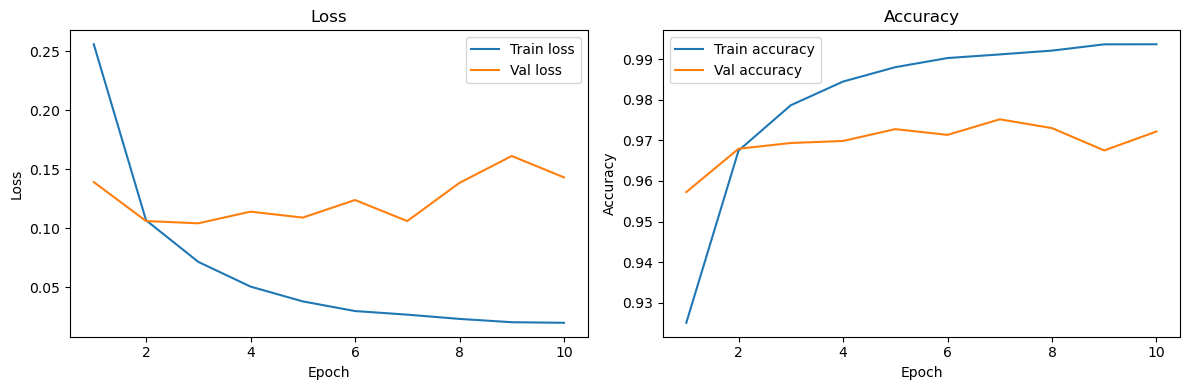

In [26]:

# history.history contains per-epoch values like: loss, val_loss, accuracy, val_accuracy
hist = history.history

epochs = range(1, len(hist["loss"]) + 1)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))  # 1 row, 2 plots

# Loss
axes[0].plot(epochs, hist["loss"], label="Train loss")
axes[0].plot(epochs, hist["val_loss"], label="Val loss")
axes[0].set_title("Loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend()

# Accuracy
axes[1].plot(epochs, hist["accuracy"], label="Train accuracy")
axes[1].plot(epochs, hist["val_accuracy"], label="Val accuracy")
axes[1].set_title("Accuracy")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].legend()

plt.tight_layout()
plt.show()


### Evaluate MLP: Classification report + confusion matrix

Before final test evaluation, examine the MLP's detailed performance on validation data using standard classification metrics. 

**What to compute:**
- **Classification report:** Precision, recall, and F1-score per digit class (0-9) to spot systematic weaknesses. 
- **Confusion matrix:** 10×10 heatmap showing where predictions go wrong (e.g., 4→9, 7→1 errors common in MNIST). 

**Why this matters:**
- Single accuracy hides class imbalances and specific failure patterns.
- Seeing per-class metrics reveals whether the model struggles with certain digits consistently.
- Confusion patterns guide next improvements (data augmentation, architecture tweaks).


MLP Classification Report (validation):
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1185
           1       0.98      0.99      0.98      1348
           2       0.98      0.96      0.97      1192
           3       0.98      0.94      0.96      1226
           4       0.97      0.98      0.98      1168
           5       0.97      0.98      0.97      1084
           6       0.98      0.99      0.99      1184
           7       0.99      0.97      0.98      1253
           8       0.92      0.98      0.95      1170
           9       0.97      0.95      0.96      1190

    accuracy                           0.97     12000
   macro avg       0.97      0.97      0.97     12000
weighted avg       0.97      0.97      0.97     12000



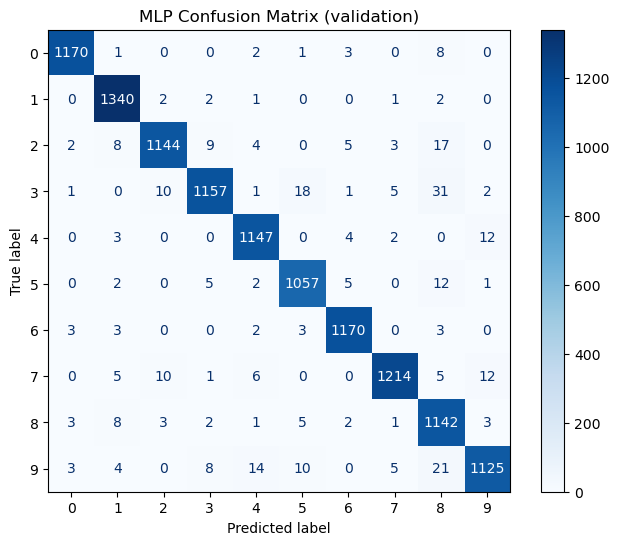

In [32]:
# ---- Classification report (validation set) ----
val_pred_mlp = mlp.predict(X_val, verbose=0)
val_pred_mlp_classes = np.argmax(val_pred_mlp, axis=1)

print("MLP Classification Report (validation):")
print(classification_report(y_val, val_pred_mlp_classes))

# ---- Confusion matrix (validation set) ----
fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay.from_predictions(y_val, val_pred_mlp_classes, ax=ax, cmap="Blues")
plt.title("MLP Confusion Matrix (validation)")
plt.show()


## Evaluation and comparison

Evaluate the trained MLP on the **test set** (never used before) and compare all three models side-by-side using the same metrics and conditions5]

**What to do:**
- Predict on test set for Logistic Regression, Decision Tree, and MLP
- Report test accuracy for all three models
- Show test confusion matrix for the MLP (to see where the neural network makes mistakes)
- Compare training time and parameter count where relevant

**What this tells you:**
- Honest final performance on unseen data (test accuracy)
- Which model generalizes best
- Whether the neural network's complexity was worth it vs simpler baselines


In [40]:
import pandas as pd

# Logistic Regression
test_pred_lr = log_reg.predict(X_test_flat)

# Decision Tree
test_pred_tree = tree.predict(X_test_flat)

# MLP predictions (already computed earlier)
test_pred_mlp_classes = np.argmax(mlp.predict(x_test.reshape(-1, 28, 28), verbose=0), axis=1)

# Now get detailed metrics
reports = {
    "logistic_regression": classification_report(y_test, test_pred_lr, output_dict=True),
    "decision_tree": classification_report(y_test, test_pred_tree, output_dict=True),
    "mlp": classification_report(y_test, test_pred_mlp_classes, output_dict=True),
}

# Build DataFrame (per-class + macro/weighted avgs)
rows = []
for model_name, rep in reports.items():
    for label, metrics in rep.items():
        if label.isdigit() or label in ("macro avg", "weighted avg"):
            rows.append({
                "model": model_name.replace("_", " ").title(),
                "label": label,
                "precision": f"{metrics['precision']:.3f}",
                "recall": f"{metrics['recall']:.3f}",
                "f1_score": f"{metrics['f1-score']:.3f}",
                "support": metrics["support"],
            })

df_metrics = pd.DataFrame(rows).set_index(["model", "label"]).sort_index(level=[0,1])

print("Test Set Precision/Recall/F1-Scores:")
print(df_metrics)


Test Set Precision/Recall/F1-Scores:
                                 precision recall f1_score  support
model               label                                          
Decision Tree       0                0.924  0.928    0.926    980.0
                    1                0.930  0.955    0.942   1135.0
                    2                0.854  0.846    0.850   1032.0
                    3                0.845  0.846    0.845   1010.0
                    4                0.870  0.862    0.866    982.0
                    5                0.842  0.830    0.836    892.0
                    6                0.887  0.897    0.892    958.0
                    7                0.889  0.894    0.891   1028.0
                    8                0.822  0.792    0.806    974.0
                    9                0.844  0.858    0.851   1009.0
                    macro avg        0.871  0.871    0.871  10000.0
                    weighted avg     0.872  0.872    0.872  10000.0
Logistic Re

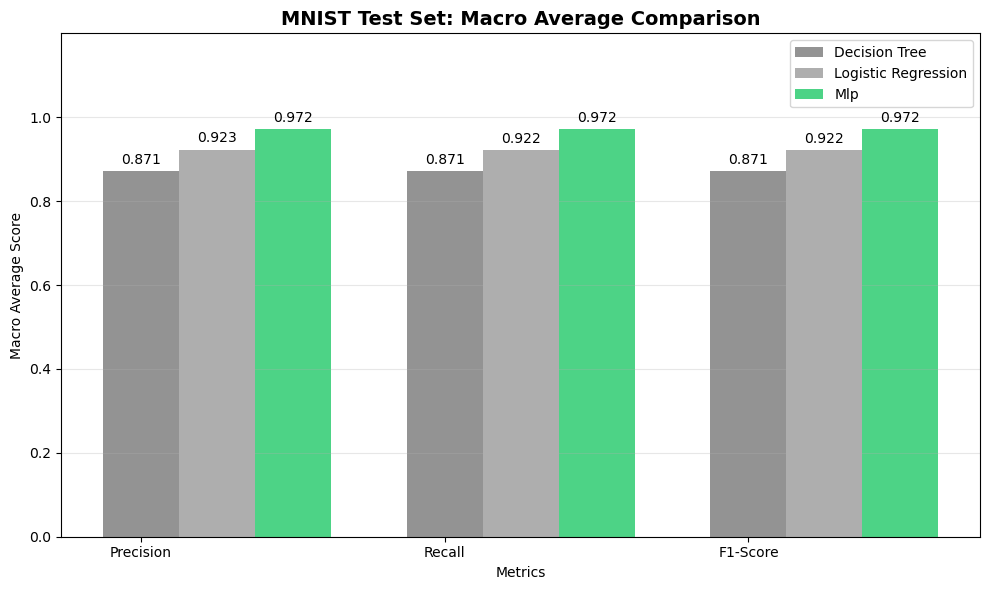

In [56]:
# Extract macro averages (already numeric)
macro_data = df_metrics[df_metrics.index.get_level_values("label") == "macro avg"]
macro_num = macro_data.drop(columns=["support"]).astype(float)

# Models and colors: gray for baselines, green for MLP
models = macro_num.index.get_level_values("model").tolist()
colors = ["#808080", "#A0A0A0", "#2ECC71"]  # gray1, gray2, green

# Create grouped bar chart
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(["Precision", "Recall", "F1-Score"]))
width = 0.25

for i, model in enumerate(models):
    scores = [macro_num.loc[(model, "macro avg"), metric] for metric in ["precision", "recall", "f1_score"]]
    ax.bar(x + i*width, scores, width, label=model, color=colors[i], alpha=0.85)

ax.set_xlabel("Metrics")
ax.set_ylabel("Macro Average Score")
ax.set_title("MNIST Test Set: Macro Average Comparison", fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(["Precision", "Recall", "F1-Score"])
ax.set_ylim(0, 1.2)
ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, model in enumerate(models):
    scores = [macro_num.loc[(model, "macro avg"), metric] for metric in ["precision", "recall", "f1_score"]]
    for j, score in enumerate(scores):
        ax.text(j + i*width, score + 0.01, f'{score:.3f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


## MNIST Classification Project Summary

### Macro Average Test Results
| Metric      | Logistic Regression | Decision Tree | MLP  |
|-------------|-------------------|---------------|------|
| **Precision** | 0.923            | 0.871        | **0.972** |
| **Recall**     | 0.922            | 0.871        | **0.972** |
| **F1-Score**   | 0.922            | 0.871        | **0.972** |

### Key Findings
- **MLP dominates** with 0.972 macro F1 (+5% over Logistic Regression, +10% over Decision Tree)
- **Logistic Regression** strong baseline (0.922), nearly matching simpler tree
- **Decision Tree** lags (0.871) - overfitting despite depth limit
- Neural network complexity justified for image data 

### Pipeline Success
Complete ML workflow: data prep → train 3 models → test evaluation → per-class metrics → visualization. MLP proves spatial pattern recognition advantage on MNIST digits.
